In [1]:
import numpy as np
from torch.autograd import Variable
import torch as torch
import copy
from torch.autograd.gradcheck import zero_gradients

import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.utils.data as data_utils
from torch.autograd import Variable
import math
import torchvision.models as models
from PIL import Image
import os

import torchfile
import cv2
import dlib

In [2]:
# Download Dlib CNN face detector
!wget http://dlib.net/files/mmod_human_face_detector.dat.bz2
!bzip2 -dk mmod_human_face_detector.dat.bz2
dnnFaceDetector=dlib.cnn_face_detection_model_v1("mmod_human_face_detector.dat")

--2020-03-05 14:00:47--  http://dlib.net/files/mmod_human_face_detector.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 694709 (678K)
Saving to: ‘mmod_human_face_detector.dat.bz2’

mmod_human_face_det 100%[===================>] 678.43K  --.-KB/s    in 0.007s  

2020-03-05 14:00:47 (102 MB/s) - ‘mmod_human_face_detector.dat.bz2’ saved [694709/694709]



In [3]:
def deepfool(image, net, num_classes=10, overshoot=0.02, max_iter=50):

    """
       :param image: Image of size HxWx3
       :param net: network (input: images, output: values of activation **BEFORE** softmax).
       :param num_classes: num_classes (limits the number of classes to test against, by default = 10)
       :param overshoot: used as a termination criterion to prevent vanishing updates (default = 0.02).
       :param max_iter: maximum number of iterations for deepfool (default = 50)
       :return: minimal perturbation that fools the classifier, number of iterations that it required, new estimated_label and perturbed image
    """
    is_cuda = torch.cuda.is_available()

    if is_cuda:
        print("Using GPU")
        image = image.cuda()
        net = net.cuda()
    else:
        print("Using CPU")


    f_image = net.forward(Variable(image[None, :, :, :], requires_grad=True)).data.cpu().numpy().flatten()
    I = (np.array(f_image)).flatten().argsort()[::-1]

    I = I[0:num_classes]
    label = I[0]

    input_shape = image.cpu().numpy().shape
    pert_image = copy.deepcopy(image)
    w = np.zeros(input_shape)
    r_tot = np.zeros(input_shape)

    loop_i = 0

    x = Variable(pert_image[None, :], requires_grad=True)
    fs = net.forward(x)
    fs_list = [fs[0,I[k]] for k in range(num_classes)]
    k_i = label

    while k_i == label and loop_i < max_iter:

        pert = np.inf
        fs[0, I[0]].backward(retain_graph=True)
        grad_orig = x.grad.data.cpu().numpy().copy()

        for k in range(1, num_classes):
            zero_gradients(x)

            fs[0, I[k]].backward(retain_graph=True)
            cur_grad = x.grad.data.cpu().numpy().copy()

            # set new w_k and new f_k
            w_k = cur_grad - grad_orig
            f_k = (fs[0, I[k]] - fs[0, I[0]]).data.cpu().numpy()

            pert_k = abs(f_k)/np.linalg.norm(w_k.flatten())

            # determine which w_k to use
            if pert_k < pert:
                pert = pert_k
                w = w_k

        # compute r_i and r_tot
        # Added 1e-4 for numerical stability
        r_i =  (pert+1e-4) * w / np.linalg.norm(w)
        r_tot = np.float32(r_tot + r_i)

        if is_cuda:
            pert_image = image + (1+overshoot)*torch.from_numpy(r_tot).cuda()
        else:
            pert_image = image + (1+overshoot)*torch.from_numpy(r_tot)

        x = Variable(pert_image, requires_grad=True)
        fs = net.forward(x)
        k_i = np.argmax(fs.data.cpu().numpy().flatten())

        loop_i += 1

    r_tot = (1+overshoot)*r_tot

    return r_tot, loop_i, label, k_i, pert_image


In [4]:
# -*- coding: utf-8 -*-

__author__ = "Pau Rodríguez López, ISELAB, CVC-UAB"
__email__ = "pau.rodri1@gmail.com"

class VGG_16(nn.Module):
    """
    Main Class
    """

    def __init__(self):
        """
        Constructor
        """
        super().__init__()
        self.block_size = [2, 2, 3, 3, 3]
        self.conv_1_1 = nn.Conv2d(3, 64, 3, stride=1, padding=1)
        self.conv_1_2 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
        self.conv_2_1 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.conv_2_2 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
        self.conv_3_1 = nn.Conv2d(128, 256, 3, stride=1, padding=1)
        self.conv_3_2 = nn.Conv2d(256, 256, 3, stride=1, padding=1)
        self.conv_3_3 = nn.Conv2d(256, 256, 3, stride=1, padding=1)
        self.conv_4_1 = nn.Conv2d(256, 512, 3, stride=1, padding=1)
        self.conv_4_2 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.conv_4_3 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.conv_5_1 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.conv_5_2 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.conv_5_3 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.fc6 = nn.Linear(512 * 7 * 7, 4096)
        self.fc7 = nn.Linear(4096, 4096)
        self.fc8 = nn.Linear(4096, 2622)

    def load_weights(self, path="VGG_FACE.t7"):
        """ Function to load luatorch pretrained

        Args:
            path: path for the luatorch pretrained
        """
        model = torchfile.load(path)
        counter = 1
        block = 1
        for i, layer in enumerate(model.modules):
            if layer.weight is not None:
                if block <= 5:
                    self_layer = getattr(self, "conv_%d_%d" % (block, counter))
                    counter += 1
                    if counter > self.block_size[block - 1]:
                        counter = 1
                        block += 1
                    self_layer.weight.data[...] = torch.tensor(layer.weight).view_as(self_layer.weight)[...]
                    self_layer.bias.data[...] = torch.tensor(layer.bias).view_as(self_layer.bias)[...]
                else:
                    self_layer = getattr(self, "fc%d" % (block))
                    block += 1
                    self_layer.weight.data[...] = torch.tensor(layer.weight).view_as(self_layer.weight)[...]
                    self_layer.bias.data[...] = torch.tensor(layer.bias).view_as(self_layer.bias)[...]

    def forward(self, x):
        """ Pytorch forward

        Args:
            x: input image (224x224)

        Returns: class logits

        """
        x = F.relu(self.conv_1_1(x))
        x = F.relu(self.conv_1_2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_2_1(x))
        x = F.relu(self.conv_2_2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_3_1(x))
        x = F.relu(self.conv_3_2(x))
        x = F.relu(self.conv_3_3(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_4_1(x))
        x = F.relu(self.conv_4_2(x))
        x = F.relu(self.conv_4_3(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_5_1(x))
        x = F.relu(self.conv_5_2(x))
        x = F.relu(self.conv_5_3(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc6(x))
        x = F.dropout(x, 0.5, self.training)
        x = F.relu(self.fc7(x))
        x = F.dropout(x, 0.5, self.training)
        return self.fc8(x)

In [5]:
labels = open(os.path.join('names.txt'), 'r').read().split('\n')

In [10]:
def create_fake(model, file_path):
    # Function for generating adveserial examples
    
    img=cv2.imread(file_path)
    gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    rects=dnnFaceDetector(gray,1)
    left,top,right,bottom=0,0,0,0
    
    for (i,rect) in enumerate(rects):
        left=rect.rect.left() #x1
        top=rect.rect.top() #y1
        right=rect.rect.right() #x2
        bottom=rect.rect.bottom() #y2
        
    width=right-left
    height=bottom-top
    img_crop=img[top:top+height,left:left+width]
    
    
    crop_height = img_crop.shape[0]
    crop_width = img_crop.shape[1]
    
    ## Resize to input size
    img_crop = cv2.resize(img_crop, (224,224), interpolation = cv2.INTER_AREA)
  
    img_crop = cv2.cvtColor(img_crop, cv2.COLOR_BGR2RGB)    
    img_pil = Image.fromarray(img_crop)
    
    
    mean = [ 0.485, 0.456, 0.406 ]
    std = [ 0.229, 0.224, 0.225 ]


    im = transforms.Compose([
        #transforms.Scale(256),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean = mean,
                         std = std)])(img_pil)
    
    
    r, loop_i, label_orig, label_pert, pert_image = deepfool(im, net)
    
    def clip_tensor(A, minv, maxv):
        A = torch.max(A, minv*torch.ones(A.shape))
        A = torch.min(A, maxv*torch.ones(A.shape))
        return A

    clip = lambda x: clip_tensor(x, 0, 255)

    tf = transforms.Compose([transforms.Normalize(mean=[0, 0, 0], std=list(map(lambda x: 1 / x, std))),
    transforms.Normalize(mean=list(map(lambda x: -x, mean)), std=[1, 1, 1]),
    transforms.Lambda(clip),
    transforms.ToPILImage(),
    transforms.CenterCrop(224)
    ])
    
    image = np.asarray(tf(pert_image.cpu()[0]))
    
    image = cv2.resize(image, (crop_width,crop_height), interpolation = cv2.INTER_AREA)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img[top:top+crop_height,left:left+crop_width] = image
              
   
    plt.figure()
    plt.imshow(img)
    title = "Orignal : "+labels[label_orig]+ "  Adversarial example : "+labels[label_pert]
    plt.title(title)
    plt.show()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.imwrite(file_path.split('.')[0]+"avd.jpeg",img)

Using GPU


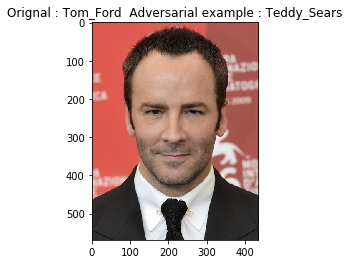

In [11]:
model = VGG_16()
model.load_weights()
net = model
net.eval()


create_fake(net,"tomford3.jpg")
